# Unidad 2 · Series temporales e índices económicos

Curso: **Estadística con Python**  

**Objetivo:** importar, tratar y analizar series económicas,
calcular tasas e índices, enlazar/deflactar y descomponer tendencia/estacionalidad.

## Índice
1. Importación y tratamiento de datos (IPC/PIB/desempleo)
2. Tasas de variación e índices (base fija y encadenados)
3. Enlace y deflactación de series
4. Introducción a `statsmodels.tsa` (tendencia/estacionalidad)
5. Caso práctico: IPC y poder adquisitivo


In [1]:
#importamos las librerías que vamos a necesitar.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa as sm

## 1. Importación y tratamiento de datos
A continuación se muestra cómo importar series temporales reales desde archivos CSV.


#### Base de datos IPC

Trabajaremos en primer lugar con la base de datos del índice de precios del consumo. Si abrimos el fichero de `IPC_ESP.csv` vemos que hay dos columnas, la primera "Periodo" donde consta el año y el mes en el formato YYYYMmm, y la segunda columna contiene el valor del IPC con "." como separador decimal. Veamos cómo extraemos y organizamos estos datos:

In [ ]:
# 1) Leemos respetando la coma como separador decimal
ipc_raw = pd.read_csv('IPC_ESP.csv', decimal=".", sep=";")  # <- convierte "118.824" en 118.824.

display(ipc_raw.head())
display(ipc_raw.tail())
display(ipc_raw.info())


,Periodo,Total
0,2025M08,118.824
1,2025M07,118.777
2,2025M06,118.867
3,2025M05,118.077
4,2025M04,117.997


,Periodo,Total
255,2004M05,75.784
256,2004M04,75.340
257,2004M03,74.322
258,2004M02,73.807
259,2004M01,73.773


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260 entries, 0 to 259
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Periodo  260 non-null    object 
 1   Total    260 non-null    float64
dtypes: float64(1), object(1)
memory usage: 4.2+ KB


None

In [ ]:

# 2) Extraemos año y mes del campo "Periodo" (formato: YYYYMmm)
#    - Con un regex capturamos el año y el mes
tmp = ipc_raw["Periodo"].astype(str).str.extract(r'(?P<year>\d{4})M(?P<month>\d{2})')
ipc_raw["Año"] = tmp["year"].astype(int)
ipc_raw["Mes"] = tmp["month"].astype(int)

# 3) Construimos una fecha al primer día de cada mes
ipc_raw["Fecha"] = pd.to_datetime(
    ipc_raw["Año"].astype(str) + "-" + ipc_raw["Mes"].astype(str) + "-01",
    format="%Y-%m-%d"
)

# 4) Serie temporal mensual (Índice al inicio de mes)
ipc_ts = ipc_raw.set_index("Fecha")["Total"].sort_index().asfreq("MS")

display(ipc_ts.head())
display(ipc_ts.tail())



,Total
Fecha,
2004-01-01,73.773
2004-02-01,73.807
2004-03-01,74.322
2004-04-01,75.340
2004-05-01,75.784


,Total
Fecha,
2025-04-01,117.997
2025-05-01,118.077
2025-06-01,118.867
2025-07-01,118.777
2025-08-01,118.824


Ahora que tienes tus datos cargados en un DataFrame con un índice temporal, puedes empezar a hacer cosas interesantes con ellos. Por ejemplo, puedes seleccionar un rango de fechas para trabajar solo con ese subconjunto de datos:

In [ ]:
# 5) Partimos en:
#    - conjunto de entrenamiento (2014-01 a 2024-12)
#    - conjunto de validación/hold-out (2025-01 a 2025-12) para calcular error de predicción
ipc_train = ipc_ts.loc["2010-01":"2024-12"]
ipc_2025  = ipc_ts.loc["2025-01":"2025-12"]  # hold-out

print("IPC (train) rango:", ipc_train.index.min().date(), "->", ipc_train.index.max().date())
print("Observaciones 2025 (hold-out):", ipc_2025.dropna().shape[0])



IPC (train) rango: 2010-01-01 -> 2024-12-01
Observaciones 2025 (hold-out): 8


**Nota:** En esta práctica no vamos a entrar en cómo calcular predicciones ni en cómo construir modelos de series temporales. Sin embargo, la división entre datos de entrenamiento y datos de validación es un paso muy habitual en el análisis de datos. Aunque ahora no la usemos, conviene que la conozcáis porque os será muy útil en el futuro cuando queráis evaluar la calidad de vuestras predicciones.

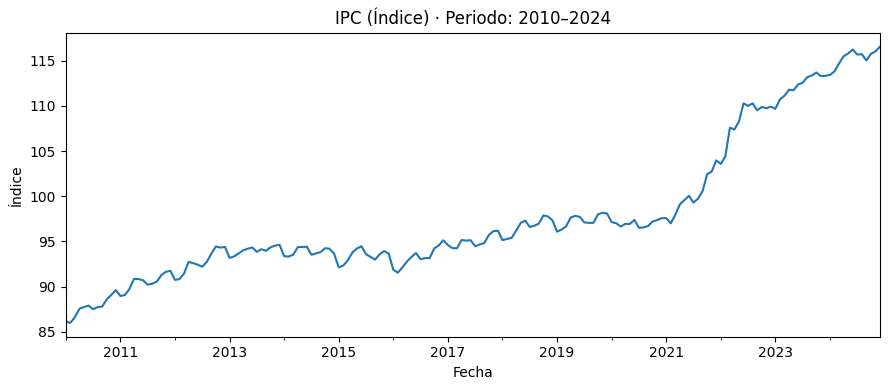

In [ ]:
# 6) Gráfico de la serie 2010–2024
ipc_train.plot(figsize=(9,4), title="IPC (Índice) · Periodo: 2010–2024")
plt.ylabel("Índice")
plt.xlabel("Fecha")
plt.tight_layout()
plt.show()

Puedes agrupar tus datos por una frecuencia temporal, como meses o años, y luego aplicar una función de agregación, como la media:


IPC media anual:
Fecha
2021-12-31    100.000083
2022-12-31    108.390667
2023-12-31    112.219417
2024-12-31    115.332583
2025-12-31    117.965750
Freq: YE-DEC, Name: Total, dtype: float64


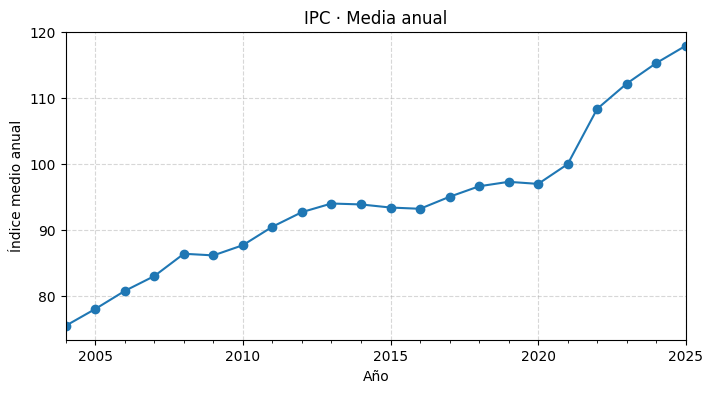

In [ ]:
# Serie temporal mensual que ya construimos
# ipc_ts: DatetimeIndex con freq="M", valores de IPC

# 1) Media anual (más común en IPC)
# YE annual resampling frequency
# QE quarterly resampling frequency
ipc_annual_mean = ipc_ts.resample("YE").mean()

# 2) Último valor de cada año (diciembre)
ipc_annual_last = ipc_ts.resample("YE").last()

# 3) También podrías calcular máximo o mínimo
ipc_annual_max = ipc_ts.resample("YE").max()
ipc_annual_min = ipc_ts.resample("YE").min()

# Mostrar resultados
print("IPC media anual:")
print(ipc_annual_mean.tail())

# Dibujamos la media anual
ipc_annual_mean.plot(figsize=(8,4), marker="o", title="IPC · Media anual")
plt.ylabel("Índice medio anual")
plt.xlabel("Año")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


#### Base de datos PIB

Realizaremos el mismo estudio ahora con el producto interior bruto. En este caso, tenemos un archivo de excel en lugar de csv. En este caso, queremos redondear a dos cifras decimales y aprenderemos a quitar filas con datos faltantes (como es el caso de 1960).

In [ ]:
# Cambiamos pd.read_csv a pd.read_excel para leer el fichero .xlsx
pib_raw = pd.read_excel('PIB_ESP.xlsx')

#Veamos las primeras filas del fichero de datos y observamos que 1960 tiene un dato faltante.
display(pib_raw.head())

,Date,Value
0,1960,NaN
1,1961,11.838674
2,1962,9.953438
3,1963,9.596499
4,1964,5.308510


Q1: ¿Qué pensáis que realiza la siguiente instrucción?

```python
   pib_raw = pib_raw.dropna(subset=["Value"]).copy()
```

In [ ]:
pib_raw = pib_raw.dropna(subset=["Value"]).copy()
display(pib_raw.head())


,Date,Value
1,1961,11.838674
2,1962,9.953438
3,1963,9.596499
4,1964,5.308510
5,1965,6.253135


La función
*dropna(subset=["Value"])* elimina las filas que tienen un valor nulo (NaN) en la columna "Value". En nuestro dataset del PIB, la fila del año 1960 no tenía datos (1960, vacío), por lo que esa fila se elimina.

El argumento subset=["Value"] indica que solo se mirará la columna "Value" para decidir qué filas borrar (y no otras columnas).

Además añadir *.copy()*  crea una copia independiente del DataFrame resultante. Esto se hace para evitar el SettingWithCopyWarning de pandas, que ocurre cuando trabajas con vistas y no con copias. Así te aseguras de que gdp sea un DataFrame nuevo y no una referencia al viejo.


In [ ]:
# El siguiente comando redondea los valores de la columna Value a dos decimales.
pib_raw["Value"] = pib_raw["Value"].astype(float).round(2)
display(pib_raw.head())

,Date,Value
1,1961,11.84
2,1962,9.95
3,1963,9.60
4,1964,5.31
5,1965,6.25


In [ ]:
# Serie temporal anual (opcional: índice anual)
# Creamos una serie temporal de periodo anual
pib_ts = pib_raw.set_index(pd.PeriodIndex(pib_raw["Date"].astype(int), freq="Y"))["Value"]
display(pib_ts.tail())

,Value
Date,
2020,-10.94
2021,6.68
2022,6.18
2023,2.68
2024,3.15


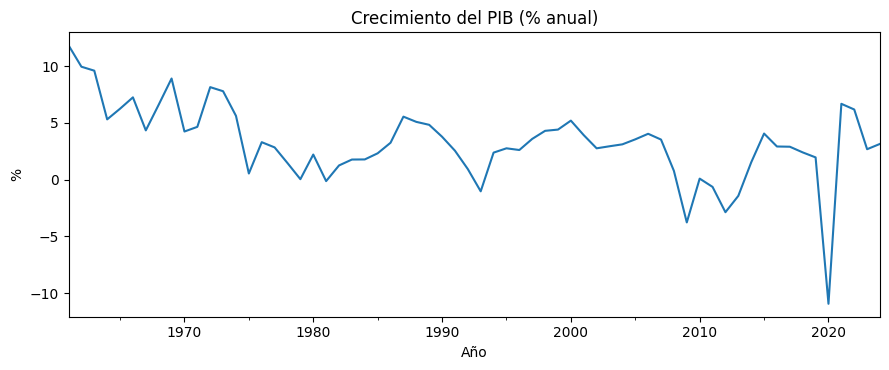

In [ ]:
# Gráfico rápido
pib_ts.plot(figsize=(9,3.8), title="Crecimiento del PIB (% anual)")
plt.ylabel("%")
plt.xlabel("Año")
plt.tight_layout()
plt.show()


##1.1 Resampleo y alineación temporal

- Convertimos a frecuencias uniformes (`Y`, anual, `M` mensual, `Q` trimestral).
- Re-muestreo para comparaciones (por ejemplo, pasar IPC mensual a anual por media).
- Dibujar conjuntamente.


Vamos a crear las dos series desde 2014 a 2024 anuales

In [ ]:
# 1) Agregar IPC mensual a anual
ipc_annual = ipc_ts.resample("YE").mean()     # media anual
# ipc_annual = ipc_ts.resample("Y").last()   # o último valor (diciembre)

# 2) PIB a DatetimeIndex anual (1 enero de cada año)
# Este paso ya lo hemos hecho antes, hemos creado pib_ts con un PeriodIndex
# pib_ts = pib_raw.set_index(pd.to_datetime(pib_raw["Date"].astype(str), format="%Y"))["Value"]


# IPC anual a columna Año (to_frame("IPC_annual")
#Convierte la Serie en un DataFrame, asignando el nombre "IPC_annual" a la columna que antes contenía los valores.)
#reset_index() Mueve el índice (que era “Fecha”) a una columna normal del DataFrame.
ipc_annual_df = ipc_annual.to_frame("IPC_annual").reset_index()
#print(ipc_annual_df.head())
#ipc_annual_df["Fecha"] Selecciona la columna que contiene las fechas (tipo datetime64[ns]).
#.dt.year Es un accesor de datetime de pandas (.dt) que permite extraer componentes de fecha (año, mes, día, etc.).
#.dt.year → devuelve el año (por ejemplo, 2020, 2021).
#.dt.month → devuelve el número de mes.
#.dt.day → devuelve el día del mes.
#Asignación: #Crea una nueva columna "Año" con esos valores extraídos.
ipc_annual_df["Año"] = ipc_annual_df["Fecha"].dt.year
#print(ipc_annual_df.head())
# Definimos ipc_annual_df como las columnas Año y IPC_annual
ipc_annual_df = ipc_annual_df[["Año", "IPC_annual"]]
#print(ipc_annual_df.head())

# PIB a columna Año
pib_df = pib_ts.to_frame("PIB_annual").reset_index()
pib_df["Año"] = pib_df["Date"].dt.year
pib_df = pib_df[["Año", "PIB_annual"]]

# Ahora filtra por rango de años con condiciones numéricas
ipc_annual_df = ipc_annual_df[(ipc_annual_df["Año"] >= 2014) & (ipc_annual_df["Año"] <= 2024)]
pib_df        = pib_df[(pib_df["Año"] >= 2014) & (pib_df["Año"] <= 2024)]

# Veamos las primeras filas de pib y ipc
display(ipc_annual_df.head())
display(ipc_annual_df.tail())
display(pib_df.head())



,Año,IPC_annual
10,2014,93.881333
11,2015,93.411583
12,2016,93.222333
13,2017,95.045833
14,2018,96.637833


,Año,IPC_annual
16,2020,96.999750
17,2021,100.000083
18,2022,108.390667
19,2023,112.219417
20,2024,115.332583


,Año,PIB_annual
53,2014,1.52
54,2015,4.06
55,2016,2.92
56,2017,2.90
57,2018,2.40


Dibujamos ambas series

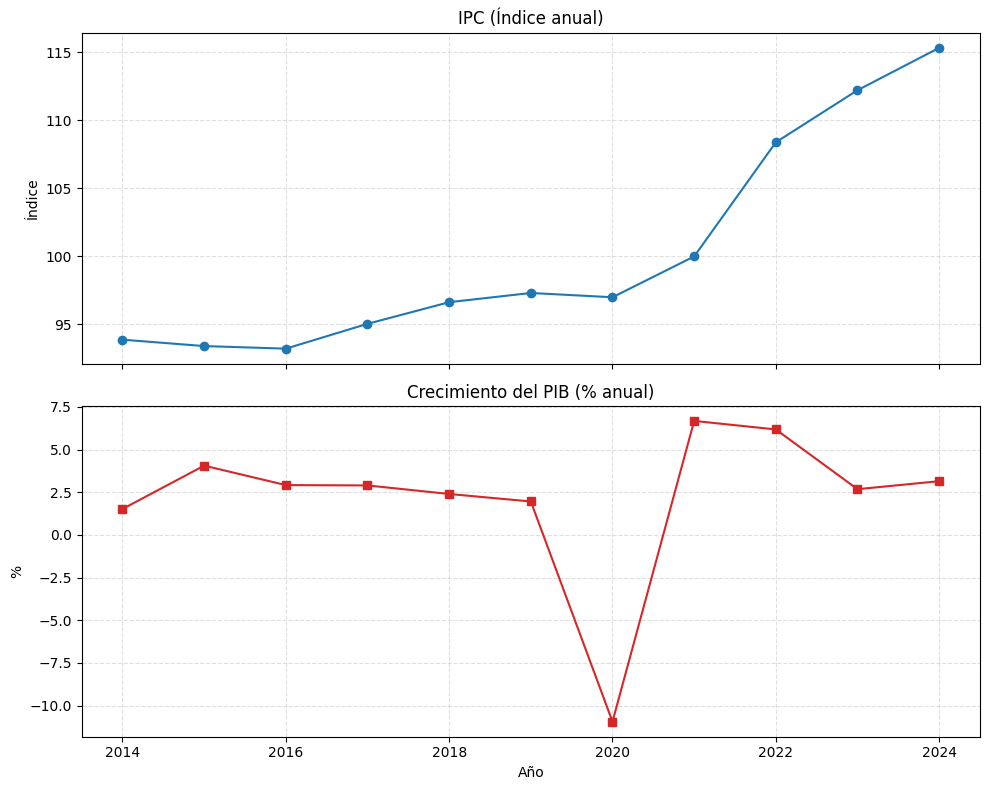

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,8), sharex=True)

# Set 'Año' as index before plotting
ipc_annual_df_indexed = ipc_annual_df.set_index("Año")
pib_df_indexed = pib_df.set_index("Año")


# --- Gráfico 1: IPC anual ---
ipc_annual_df_indexed["IPC_annual"].plot(ax=ax1, color="tab:blue", marker="o")
ax1.set_title("IPC (Índice anual)")
ax1.set_ylabel("Índice")
ax1.grid(True, linestyle="--", alpha=0.4)

# --- Gráfico 2: PIB anual ---
pib_df_indexed["PIB_annual"].plot(ax=ax2, color="tab:red", marker="s")
ax2.set_title("Crecimiento del PIB (% anual)")
ax2.set_ylabel("%")
ax2.grid(True, linestyle="--", alpha=0.4)

# Ajustes finales
plt.xlabel("Año")
plt.tight_layout()
plt.show()

#### Exportar una serie temporal creada.

En ocasiones puede resultar interesante guardar una serie temporal que ya hemos recortado y limpiado, con el fin de reutilizarla en otra práctica o análisis posterior. Para ello, podemos emplear el comando to_csv.

In [ ]:
# a) IPC limpio (con punto decimal y columna Fecha estándar)
ipc_clean = ipc_ts.rename("IPC_Index").to_frame()
ipc_clean.to_csv("ipc_clean.csv", float_format="%.3f", date_format="%Y-%m-%d")  # 3 decimales por si acaso

# b) IPC 2004–2024 para modelado
ipc_train.to_frame(name="IPC_Index").to_csv("ipc_train_2004_2024.csv",
                                            float_format="%.3f", date_format="%Y-%m-%d")

# c) 2025 (hold-out) para evaluar predicciones más adelante
ipc_2025.to_frame(name="IPC_Index").to_csv("ipc_holdout_2025.csv",
                                           float_format="%.3f", date_format="%Y-%m-%d")

# d) PIB redondeado (2 decimales)
# Convert the pib_ts Series to a DataFrame and reset the index to get 'Date' as a column
pib_df_to_export = pib_ts.to_frame(name="Value").reset_index()
pib_df_to_export = pib_df_to_export.rename(columns={'index': 'Date'}) # Rename the index column to 'Date'
pib_df_to_export["Value"] = pib_df_to_export["Value"].round(2) # Round the Value column
pib_df_to_export.to_csv("pib_clean.csv", index=False, float_format="%.2f")


**Práctica 1**

1. Importa una serie real (por ejemplo, tasa de paro) desde un CSV y conviértela en índice temporal mensual.
2. Re-muestrea a trimestral (media de cada trimestre) y haz el gráfico de ambas series.
3. Comenta las diferencias.

## 2. Tasas de variación e índices económicos

### 2.1. Índices simples


Cómo hemos visto los índices simples tanto como referencia fija o variable son muy fáciles de calcular. Veamos en python. Usaremos un ejemplo sencillo basado en el salario medio des del 2020 al 2024.  


In [ ]:
# Datos
data = {
    "Año": [2020, 2021, 2022, 2023, 2024],
    "Salario_medio": [26.028, 27.570, 28.780, 30.250, 31.698]
}
salario = pd.DataFrame(data)

# Índice simple (base 2020)
base = salario.loc[salario["Año"] == 2020, "Salario_medio"].values[0]
salario["Indice_simple"] = (salario["Salario_medio"] / base) * 100

# Índice en cadena (respecto al año anterior)
#.pct_change() devuelve la tasa de crecimiento relativa al periodo anterior.
#Es muy útil para pasar de valores absolutos (salario, IPC, PIB…) a variaciones porcentuales o índices en cadena.
salario["Indice_cadena"] = salario["Salario_medio"].pct_change() * 100 + 100

display(salario)


,Año,Salario_medio,Indice_simple,Indice_cadena
0,2020,26.028,100.000000,NaN
1,2021,27.570,105.924389,105.924389
2,2022,28.780,110.573229,104.388828
3,2023,30.250,116.220993,105.107714
4,2024,31.698,121.784232,104.786777


Q2: Repite este cálculo para los datos del IPC anual para los últimos 5 años (del 2020 al 2024) con base 2020


In [ ]:
# Datos IPC anual base=2020
df_ipc = pd.DataFrame({
    "Año": [2020, 2021, 2022, 2023, 2024],
    "IPC_annual": [96.999750, 100.000083, 108.390667, 112.219417, 115.332583]
})

base_2020 = df_ipc.loc[df_ipc["Año"]==2020, "IPC_annual"].values[0]
df_ipc["Indice_simple_base2020"] = df_ipc["IPC_annual"] / base_2020 * 100
df_ipc["Indice_cadena"] = df_ipc["IPC_annual"].pct_change() * 100 + 100
display(df_ipc)

,Año,IPC_annual,Indice_simple_base2020,Indice_cadena
0,2020,96.999750,100.000000,NaN
1,2021,100.000083,103.093135,103.093135
2,2022,108.390667,111.743244,108.390577
3,2023,112.219417,115.690419,103.532361
4,2024,115.332583,118.899877,102.774178



### 2.2. Tasas de variación

Las Tasas de variación pueden ser respecto al periodo base, o respecto al periodo anterior.  

Respecto al periodo base se calcula como:
$$ \Delta_0 = \frac{X_t - X_{0}}{X_{0}} \times 100$$


Respecto al periodo anterior se calcula como:
$$ \Delta_t = \frac{X_t - X_{t-1}}{X_{t-1}} \times 100$$




In [ ]:
# --- Calcular tasas de variación ---
# Corrected column name from 'Indice simple' to 'Indice_simple'
salario["Tasa_var0_%"] = salario["Indice_simple"] - 100
# Corrected column name from 'Indice simple_base2020' to 'Indice_simple_base2020'
df_ipc["Tasa_var0_%"] = df_ipc["Indice_simple_base2020"] - 100
salario["Tasa_var_%"] = salario["Salario_medio"].pct_change() * 100
df_ipc["Tasa_var_%"] = df_ipc["IPC_annual"].pct_change() * 100
display(salario)
display(df_ipc)

,Año,Salario_medio,Indice_simple,Indice_cadena,Tasa_var0_%,Tasa_var_%
0,2020,26.028,100.000000,NaN,0.000000,NaN
1,2021,27.570,105.924389,105.924389,5.924389,5.924389
2,2022,28.780,110.573229,104.388828,10.573229,4.388828
3,2023,30.250,116.220993,105.107714,16.220993,5.107714
4,2024,31.698,121.784232,104.786777,21.784232,4.786777


,Año,IPC_annual,Indice_simple_base2020,Indice_cadena,Tasa_var0_%,Tasa_var_%
0,2020,96.999750,100.000000,NaN,0.000000,NaN
1,2021,100.000083,103.093135,103.093135,3.093135,3.093135
2,2022,108.390667,111.743244,108.390577,11.743244,8.390577
3,2023,112.219417,115.690419,103.532361,15.690419,3.532361
4,2024,115.332583,118.899877,102.774178,18.899877,2.774178


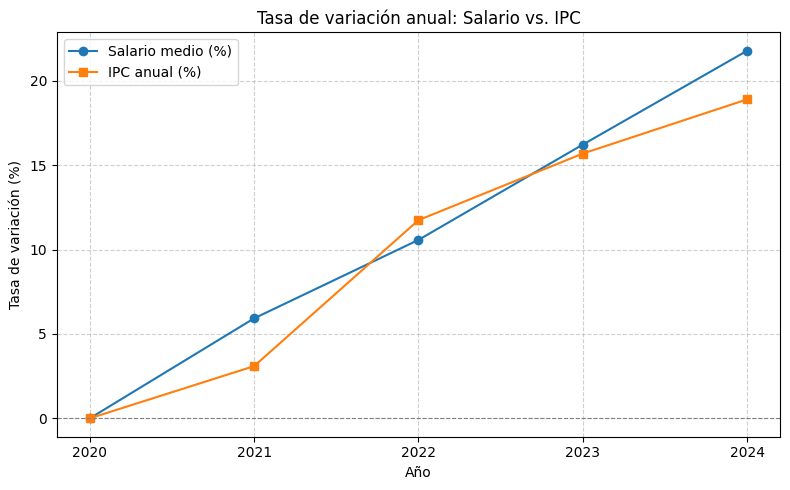

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(salario["Año"], salario["Tasa_var0_%"], marker="o", label="Salario medio (%)")
plt.plot(df_ipc["Año"], df_ipc["Tasa_var0_%"], marker="s", label="IPC anual (%)")

plt.axhline(0, color="gray", linestyle="--", linewidth=0.8)
plt.title("Tasa de variación anual: Salario vs. IPC")
plt.xlabel("Año")
plt.ylabel("Tasa de variación (%)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)

# Forzar ticks solo en años enteros
plt.xticks(df_ipc["Año"])

plt.tight_layout()
plt.show()

### 2.3 índices complejos: Laspeyres, Paasche

Supongamos una economía sencilla con 4 tipos de bienes: alimentación, vivienda, transporte y ocio.
Disponemos de sus precios y cantidades tanto en el periodo base (0) como en el periodo actual (t).

A partir de esta información construiremos una cesta de consumo representativa que nos permitirá calcular los índices de precios de Laspeyres y Paasche.

**Fórmulas**  
- Laspeyres:  $P_L = \frac{\sum p_t q_0}{\sum p_0 q_0}$
- Paasche: $P_P = \frac{\sum p_t q_t}{\sum p_0 q_t} $
- Fisher: $P_F = \sqrt{P_L\,P_P}$

In [ ]:
data = {
    "Bien": ["Alimentación", "Vivienda", "Transporte", "Ocio"],
    "p0":   [100, 200, 50, 80],   # precios base
    "q0":   [10, 5, 12, 6],       # cantidades base
    "pt":   [110, 220, 60, 90],   # precios actuales
    "qt":   [9, 5, 11, 7]         # cantidades actuales
}
df = pd.DataFrame(data)

# Índices simples por bien
df["I_i"] = df["pt"] / df["p0"]

# Pesos Laspeyres y Paasche (en numerador/denominador)
df["wL"] = df["p0"] * df["q0"]      # valores base
df["wP"] = df["p0"] * df["qt"]      # valores a precios base con cantidades actuales

# --- Índice de Laspeyres ---
PL_num = (df["pt"] * df["q0"]).sum()
PL_den = (df["p0"] * df["q0"]).sum()
P_L = PL_num / PL_den

# --- Índice de Paasche  ---
PP_num = (df["pt"] * df["qt"]).sum()
PP_den = (df["p0"] * df["qt"]).sum()
P_P = PP_num / PP_den

# --- Fisher ---
P_F = np.sqrt(P_L * P_P)

print(f"Laspeyres P_L = {P_L:.4f}  (×100 = {P_L*100:.2f})")
print(f"Paasche   P_P = {P_P:.4f}  (×100 = {P_P*100:.2f})")
print(f"Fisher    P_F = {P_F:.4f}  (×100 = {P_F*100:.2f})")

# Si quieres reportar como índice (base=100):
PL_100 = P_L * 100
PP_100 = P_P * 100
PF_100 = P_F * 100


Laspeyres P_L = 1.1234  (×100 = 112.34)
Paasche   P_P = 1.1229  (×100 = 112.29)
Fisher    P_F = 1.1232  (×100 = 112.32)


Interpretación: si $PL=1.10$, reportado como 110, significa un aumento del +10% de precios respecto al periodo base para esa cesta.

**Práctica 2**

1. Calcula la tasa trimestral del PIB nominal (comparando con el trimestre anterior).
2. Construye un índice base para el PIB (elige un trimestre base) y haz la gráfica.
3. ¿Qué ventajas tiene comparar en índice base frente a valores absolutos?

## 3. Enlace y deflactación

### 3.1. Cambio de base
Cuando se dispone de una serie de números índices en
la que el periodo base queda muy alejado en el tiempo,
se puede cambiar a un periodo base más reciente la
base para facilitar la interpretación de los mismos.
Así se evita la pérdida de representatividad de los
índices al alejarnos del periodo base.
El procedimiento a seguir es similar al del enlace, y la
regla de tres se plantea comparando con 100 el valor
del índice observado en el periodo que se quiere tomar
como nueva base.

A partir de los índices simples de la base de datos salario vamos a ver cómo se calcula el cambio de base.



In [ ]:
# Índice simple (base 2021)
base_2021 = salario.loc[salario["Año"] == 2021, "Salario_medio"].values[0]
salario["Indice_base2021"] = (salario["Salario_medio"] / base_2021) * 100

display(salario)

,Año,Salario_medio,Indice_simple,Indice_cadena,Tasa_var0_%,Tasa_var_%,Indice_base2021
0,2020,26.028,100.000000,NaN,0.000000,NaN,94.406964
1,2021,27.570,105.924389,105.924389,5.924389,5.924389,100.000000
2,2022,28.780,110.573229,104.388828,10.573229,4.388828,104.388828
3,2023,30.250,116.220993,105.107714,16.220993,5.107714,109.720711
4,2024,31.698,121.784232,104.786777,21.784232,4.786777,114.972797


### 3.2. Enlace de series

Uno de los problemas que se encontramos en la
práctica cuando se trabaja con números índices es la
presencia de series de números índices con distinto
periodo base referidas a la misma variable.
Dado que los índices de los dos periodos no se pueden
comparar entre sí, en la práctica se suele realizar el
enlace de las series para contar con una sola serie de
índices que tenga la base común.
El enlace se elabora mediante reglas de tres que
relacionan las series a enlazar, para lo cual se necesita
disponer en, *al menos un periodo*, de la información
correspondiente a las dos series.

Los datos *IPCbase.xlsx* contiene el IPC con base 2021 y base 2002 pero no se tienen los datos para toda la serie en ninguna de las dos bases.

Para el año 2019 tenemos el ipc en las dos bases, esta información es indispensable para poder calcular la serie en todo el periodo. La relación

$$ k=\frac{I^{2021}_{2019} }{ I^{2002}_{2019}}$$

se conoce como **coeficiente de enlace** con base 2021.

Se pide obtener una serie única para la base de 2021.  


In [ ]:
import pandas as pd

# 1) Leer el Excel y normalizar números con coma
ipc_b = pd.read_excel('IPCbase.xlsx')  # columnas: Periodo, IPC_base2021, IPC_base2002

display(ipc_b.head())

# Ordenar por año y usarlo como índice
ipc_b = ipc_b.sort_values("Periodo").set_index("Periodo")

# 2) Coeficiente de enlace con el año 2019
val_2021_2019 = ipc_b.loc[2019, "IPC_base2021"]
val_2002_2019 = ipc_b.loc[2019, "IPC_base2002"]
k = val_2021_2019 / val_2002_2019
print(f"Coeficiente de enlace k (2019): {k:.6f}")

# 3) Convertir la base 2002 a escala base 2021
ipc_b["base2002_a_base2021"] = ipc_b["IPC_base2002"] * k

# 4) Serie enlazada en base 2021:
#    - usa IPC_base2021 cuando existe,
#    - rellena con base2002 convertida cuando falte.
ipc_b["IPC_enlazado_base2021"] = ipc_b["IPC_base2021"].fillna(ipc_b["base2002_a_base2021"])

# (Comprobación) En 2019 ambas deben coincidir (salvo redondeos)
display(ipc_b.loc[2019, ["IPC_base2021", "base2002_a_base2021", "IPC_enlazado_base2021"]])

# Vista rápida
display(ipc_b[["IPC_base2021", "IPC_base2002", "IPC_enlazado_base2021"]].tail(10))

,Periodo,IPC_base2021,IPC_base2002
0,2024,115.333,NaN
1,2023,112.219,NaN
2,2022,108.391,NaN
3,2021,100.000,NaN
4,2020,97.000,99.677333


Coeficiente de enlace k (2019): 0.966380


,2019
IPC_base2021,97.314
base2002_a_base2021,97.314
IPC_enlazado_base2021,97.314


,IPC_base2021,IPC_base2002,IPC_enlazado_base2021
Periodo,,,
2015,NaN,99.500431,96.155227
2016,NaN,99.796600,96.441438
2017,NaN,101.956620,98.528838
2018,NaN,101.674978,98.256666
2019,97.314,100.699518,97.314000
2020,97.000,99.677333,97.000000
2021,100.000,NaN,100.000000
2022,108.391,NaN,108.391000
2023,112.219,NaN,112.219000


Q3: Cómo sería el cálculo en Python para rellenar los datos de 2002?

In [ ]:
# 5) Serie enlazada en base 2002 haciendo el camino inverso
k_inv = 1 / k
ipc_b["base2021_a_base2002"] = ipc_b["IPC_base2021"] * k_inv
ipc_b["IPC_enlazado_base2002"] = ipc_b["IPC_base2002"].fillna(ipc_b["base2021_a_base2002"])


# Vista rápida
display(ipc_b[["IPC_base2021", "IPC_base2002", "IPC_enlazado_base2021", "IPC_enlazado_base2002"]].tail(10))


,IPC_base2021,IPC_base2002,IPC_enlazado_base2021,IPC_enlazado_base2002
Periodo,,,,
2015,NaN,99.500431,96.155227,99.500431
2016,NaN,99.796600,96.441438,99.796600
2017,NaN,101.956620,98.528838,101.956620
2018,NaN,101.674978,98.256666,101.674978
2019,97.314,100.699518,97.314000,100.699518
2020,97.000,99.677333,97.000000,99.677333
2021,100.000,NaN,100.000000,103.478963
2022,108.391,NaN,108.391000,112.161882
2023,112.219,NaN,112.219000,116.123057


### Deflactar series

Los números índices, y en especial los números índices de precios, tienen aplicaciones muy importante en el mundo real.

Una función importante del dinero es la de pasar de unidades físicas a una unidad de cuenta común, mediante una valoración de los distintos bienes y servicios, generalmente mediante la utilización de un sistema de precios.

Realizada la homogeneización podemos efectuar comparaciones en base a la unidad de cuenta común, siempre que no se hayan producido cambios en los precios de determinados artículos.

En otras palabras, la comparación es posible cuando la valoración se realiza a precios constantes de un período determinado, y no cuando se efectúa a precios corrientes, precios de cada preíodo.

El procedimiento que permite transformar una serie expresada en valores corrientes a valores constantes se conoce como **deflactación de la serie** y al índice elegido para diche transaformación se le llama **deflactor**.



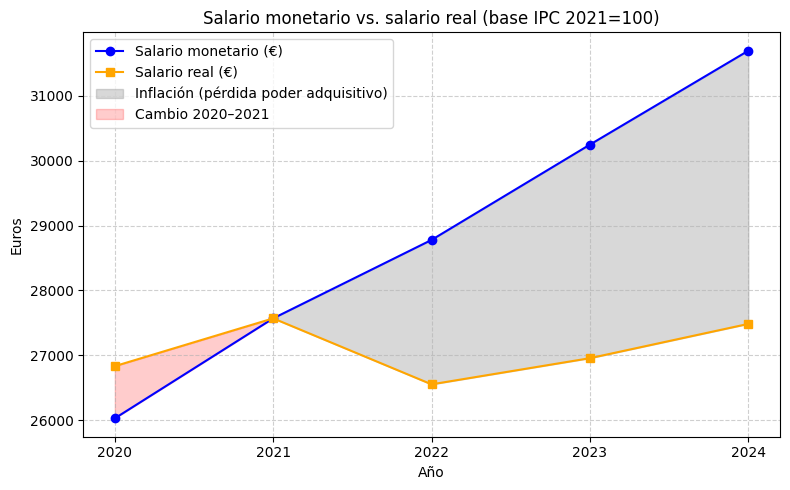

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Datos
df = pd.DataFrame({
    "Año": [2020, 2021, 2022, 2023, 2024],
    "Salario_monetario": [26028, 27570, 28780, 30250, 31698],
    "IPC": [97.00, 100.00, 108.39, 112.22, 115.33]
})

# Calcular salario real (deflactado)
df["Salario_real"] = (df["Salario_monetario"] / df["IPC"]) * 100

# Gráfica
plt.figure(figsize=(8,5))
plt.plot(df["Año"], df["Salario_monetario"], marker="o", label="Salario monetario (€)", color="blue")
plt.plot(df["Año"], df["Salario_real"], marker="s", label="Salario real (€)", color="orange")

# Sombreado entre las dos líneas
plt.fill_between(df["Año"], df["Salario_monetario"], df["Salario_real"],
                 where=(df["Salario_monetario"] >= df["Salario_real"]),
                 color="gray", alpha=0.3, label="Inflación (pérdida poder adquisitivo)")

# Sombreado específico entre 2020 y 2021
mask = (df["Año"] >= 2020) & (df["Año"] <= 2021)
plt.fill_between(df.loc[mask, "Año"],
                 df.loc[mask, "Salario_monetario"],
                 df.loc[mask, "Salario_real"],
                 color="red", alpha=0.2, label="Cambio 2020–2021")

plt.title("Salario monetario vs. salario real (base IPC 2021=100)")
plt.xlabel("Año")
plt.ylabel("Euros")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.xticks(df["Año"])  # solo años en eje X
plt.tight_layout()
plt.show()


Entre 2020 y 2021 (COVID) se observa un aumento nominal del salario, pero al ajustarlo por inflación, la ganancia de poder adquisitivo fue más moderada. El área roja destaca este efecto.



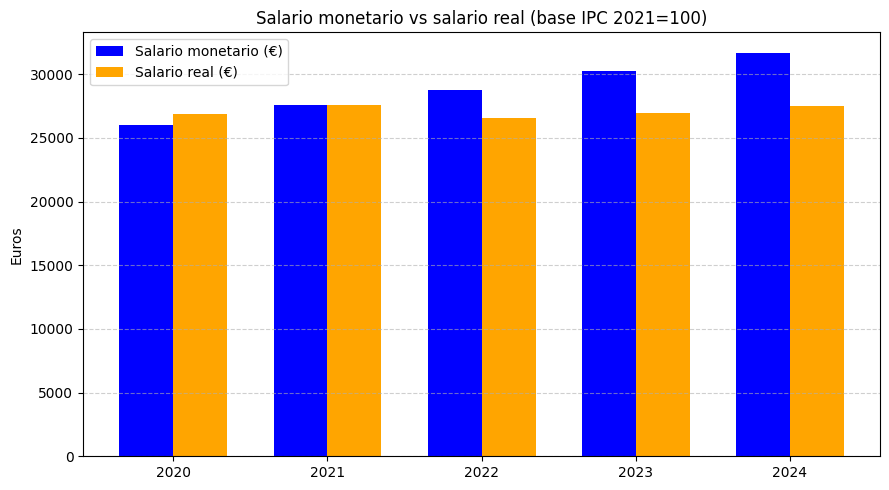

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Datos
df = pd.DataFrame({
    "Año": [2020, 2021, 2022, 2023, 2024],
    "Salario_monetario": [26028, 27570, 28780, 30250, 31698],
    "IPC": [97.00, 100.00, 108.39, 112.22, 115.33]
})

# Calcular salario real (deflactado)
df["Salario_real"] = (df["Salario_monetario"] / df["IPC"]) * 100

# Gráfico de barras agrupadas
x = np.arange(len(df["Año"]))  # posiciones
width = 0.35  # ancho de cada barra

plt.figure(figsize=(9,5))
plt.bar(x - width/2, df["Salario_monetario"], width, label="Salario monetario (€)", color="blue")
plt.bar(x + width/2, df["Salario_real"], width, label="Salario real (€)", color="orange")

# Ejes y detalles
plt.xticks(x, df["Año"])  # solo años como etiquetas
plt.title("Salario monetario vs salario real (base IPC 2021=100)")
plt.ylabel("Euros")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


Las barras azules muestran la evolución del salario en euros corrientes.

Las barras naranjas reflejan el salario ajustado por inflación.

En todos los años, la barra naranja queda por debajo, es decir, el salario real es menor que el nominal.

La diferencia indica la pérdida de poder adquisitivo.

## 4. Introducción al análisis de la tendencia con statsmodel.tsa



   Periodo  IPC_base2021
0     2024       115.333
1     2023       112.219
2     2022       108.391
3     2021       100.000
4     2020        97.000


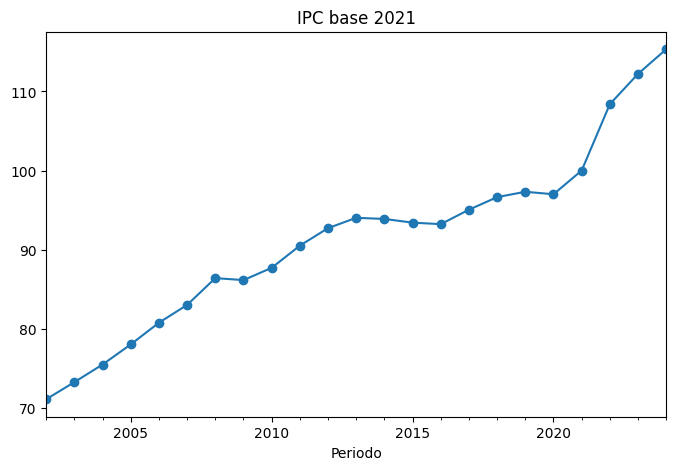

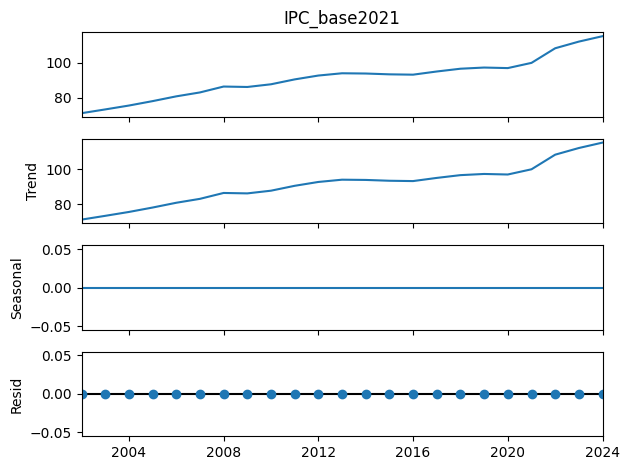

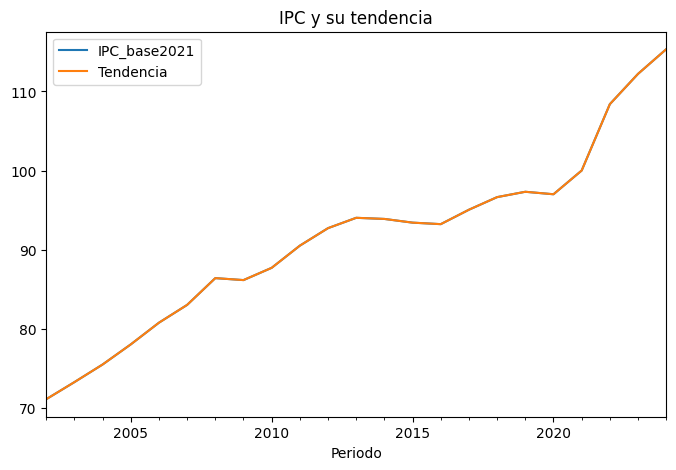

In [ ]:
# 1. Importación de librerías
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# 2. Datos IPC (2002–2024) # estos datos se pueden bajar de IPCbase21.xlsx
#Leer el Excel y normalizar números con coma
ipc = pd.read_excel('IPCbase21.xlsx')  # columnas: Periodo, IPC_base2021

d(ipc.head())
# Si introducimos los datos de manera manual
#data = {
#   "Periodo": [2024,2023,2022,2021,2020,2019,2018,2017,2016,2015,
#              2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,
#                2004,2003,2002],
#    "Total": [115.333,112.219,108.391,100.000,97.000,97.314,96.638,95.046,
#              93.222,93.412,93.881,94.023,92.717,90.504,87.701,86.150,
#              86.399,83.015,80.765,78.022,75.479,73.253,71.092]
#}
# ipc = pd.DataFrame(data)

# 3. Convertir a serie temporal con frecuencia anual
ipc = ipc.sort_values("Periodo")
ipc.index = pd.to_datetime(ipc["Periodo"], format="%Y")

# 4. Visualizar IPC
ipc["IPC_base2021"].plot(marker="o", figsize=(8,5), title="IPC base 2021")
plt.show()

# 5. Descomposición of the series
# Updated column name to 'IPC_base2021' to match the Excel data
result = seasonal_decompose(ipc["IPC_base2021"], model="additive", period=1)
result.plot()
plt.show()

# 6. Extraer tendencia
# Updated column names to 'IPC_base2021' and 'Tendencia'
ipc["Tendencia"] = result.trend
ipc[["IPC_base2021", "Tendencia"]].plot(figsize=(8,5), title="IPC y su tendencia")
plt.show()

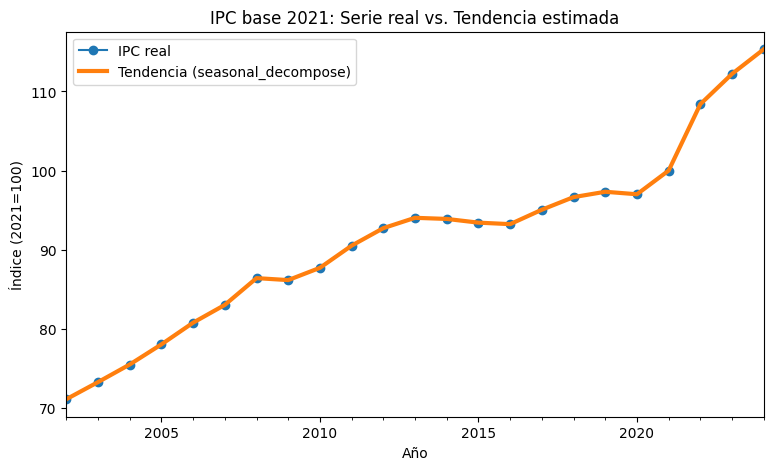

In [ ]:
# Serie original vs. tendencia estimada
fig, ax = plt.subplots(figsize=(9,5))

# Serie original
ipc["IPC_base2021"].plot(ax=ax, marker="o", lw=1.5, color="tab:blue", label="IPC real")

# Tendencia suavizada con seasonal_decompose
ipc["Tendencia"].plot(ax=ax, lw=3, color="tab:orange", label="Tendencia (seasonal_decompose)")

ax.set_title("IPC base 2021: Serie real vs. Tendencia estimada")
ax.set_xlabel("Año")
ax.set_ylabel("Índice (2021=100)")
ax.legend()
plt.show()

**PRÁCTICA**

Usando la descomposición de la serie, compara el IPC de 2002 con el de 2024.

Calcula el incremento porcentual en términos reales y explica qué implica para el poder adquisitivo.


In [ ]:
import pandas as pd

# Datos del IPC base 2021
data = {
    "Periodo": [2024,2023,2022,2021,2020,2019,2018,2017,2016,2015,
                2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,
                2004,2003,2002],
    "Total": [115.333,112.219,108.391,100.000,97.000,97.314,96.638,95.046,
              93.222,93.412,93.881,94.023,92.717,90.504,87.701,86.150,
              86.399,83.015,80.765,78.022,75.479,73.253,71.092]
}
ipc = pd.DataFrame(data).sort_values("Periodo").reset_index(drop=True)

# IPC inicial y final
ipc_2002 = ipc.loc[ipc["Periodo"] == 2002, "Total"].values[0]
ipc_2024 = ipc.loc[ipc["Periodo"] == 2024, "Total"].values[0]

# Cálculo del incremento porcentual
delta_pct = ((ipc_2024 - ipc_2002) / ipc_2002) * 100

print(f"IPC 2002 = {ipc_2002:.3f}")
print(f"IPC 2024 = {ipc_2024:.3f}")
print(f"Incremento porcentual 2002–2024: {delta_pct:.1f}%")

# Interpretación
if delta_pct > 0:
    print(f"El IPC ha subido un {delta_pct:.1f}% en 22 años, "
          "lo que significa que, de media, los precios se han encarecido "
          "y el poder adquisitivo se reduce si los salarios no crecen al mismo ritmo.")
else:
    print(f"El IPC ha bajado un {abs(delta_pct):.1f}% en 22 años, "
          "lo que implica una reducción general de precios (deflación).")


IPC 2002 = 71.092
IPC 2024 = 115.333
Incremento porcentual 2002–2024: 62.2%
El IPC ha subido un 62.2% en 22 años, lo que significa que, de media, los precios se han encarecido y el poder adquisitivo se reduce si los salarios no crecen al mismo ritmo.


**Referencias**

Yves J. Hilpisch *Python for Finance (2nd ed.)*
Mastering Data-Driven Finance

S. de la Fuente. (2010) *Estadística descriptiva: números índices* Universidad Autónoma de Madrid.

